## GTZAN Dataset - Music Genre Classification

#### Context
Music. Experts have been trying for a long time to understand sound and what differenciates one song from another. How to visualize sound. What makes a tone different from another.

#### Content
genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)
images original - A visual representation for each audio file. One way to classify data is through neural networks. Because NNs (like CNN, what we will be using today) usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible.

#### Link
https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

import IPython.display as ipd

from pydub import AudioSegment
from pydub.utils import make_chunks

from tqdm import tqdm

In [2]:
# Function to split audio into 5 second chunks
def audioSplit(audio_path, export_path):
    audio = AudioSegment.from_file(audio_path , "wav") 
    chunks = make_chunks(audio, 5000) #Make chunks of five sec
    
    for i, chunk in enumerate(chunks):
        if i < 6:
            audio_name = os.path.basename(audio_path).replace('.wav', '')
            chunk_name = f'{audio_name}.{i}.wav'
            print("exporting", chunk_name)
            chunk.export(out_f=export_path + '\\' + chunk_name, format="wav")

In [3]:
# Split Audio 
genres_path = 'Data\\genres'
genres = os.listdir(genres_path)

# Create directory for split audios
new_path = 'Data\\5sec_data'

if not os.path.exists(new_path):
    os.mkdir('Data\\5sec_data')
    folder_path = 'Data\\5sec_data'

    for genre in genres:
        # populate parent folder with genres folders
        os.mkdir(folder_path + '\\' + genre)

        # split songs and export
        songs = os.listdir(genres_path + '\\' + genre)
        for song in songs:
            song_path = genres_path + '\\' + genre + '\\' + song
            export_path = f'Data\\5sec_data\\{genre}'
            try:
                audioSplit(song_path,export_path)
            except Exception as e:
                print("Error encountered while splitting file: ", e)

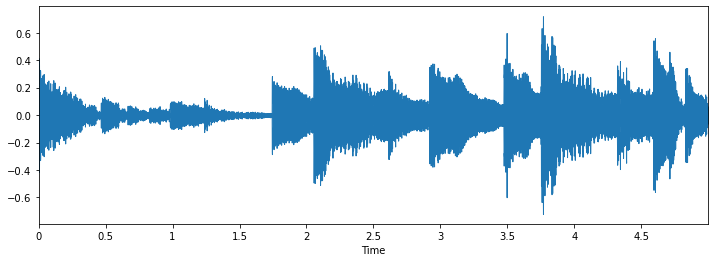

In [4]:
filename = 'Data\\5sec_data\\blues\\blues.00006.1.wav'

plt.figure(figsize=(12,4))
data, sample_rate = librosa.load(filename)

librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename, rate=sample_rate)

In [5]:
# Create Dataframe of file_name and genre
folder_path = 'Data\\5sec_data\\'
songs_array = []
for genre in genres:
    songs = os.listdir(folder_path + genre)
    for song in songs:
        label = song.split('.')[0]
        songs_array.append([song, genre])

columns = ['file_name', 'class']      
df = pd.DataFrame(data=songs_array, columns=columns)
df.head()

,file_name,class
0,blues.00000.0.wav,blues
1,blues.00000.1.wav,blues
2,blues.00000.2.wav,blues
3,blues.00000.3.wav,blues
4,blues.00000.4.wav,blues


In [6]:
# Check if dataset is imbalanced
df['class'].value_counts()

reggae       600
blues        600
rock         600
disco        600
metal        600
country      600
pop          600
hiphop       600
classical    600
jazz         594
Name: class, dtype: int64

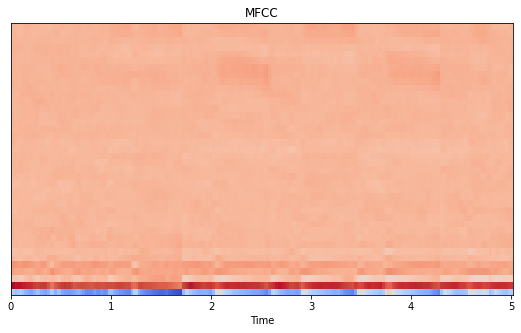

In [7]:
# mfccs
plt.figure(figsize=(9,5))
mfcc_data = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
mfcc_data.shape
librosa.display.specshow(mfcc_data, x_axis='time')
plt.title('MFCC')
plt.xticks(np.arange(0, 6, 1.0))
plt.show()

In [8]:
# Function to extract features
def features_extractor(file):
    data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [12]:
# Extract MFCC of all songs
extracted_features = []
for genre in genres:
    songs = os.listdir(folder_path + genre)
    for song in tqdm(songs):
        file_name = folder_path + genre + '\\' + song
        try:
            features = features_extractor(file_name)
            extracted_features.append([features, genre])
        except Exception as e:
            print('Error extracting features: ', e)        

100%|██████████| 600/600 [00:12<00:00, 49.76it/s]


In [9]:
# Convert extracted features to dataframe
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df.to_pickle('audio_features')
df = pd.read_pickle('audio_features')
df.head()

,feature,class
0,"[-119.049614, 124.37452, -22.895323, 42.133842...",blues
1,"[-131.87692, 116.83156, -14.442629, 48.357845,...",blues
2,"[-108.93312, 134.33325, -19.547112, 40.93205, ...",blues
3,"[-102.46034, 113.589455, -16.052588, 43.914845...",blues
4,"[-107.68676, 125.12887, -20.65988, 41.452744, ...",blues


In [10]:
# Split dataset to independent and dependent dataset
X = np.array(df['feature'].tolist())
y = np.array(df['class'].tolist())

In [11]:
X.shape

(5994, 40)

In [12]:
# Label Encode y values
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [13]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4795, 40)
(1199, 40)
(4795, 10)
(1199, 10)


In [15]:
X_train

array([[-121.305305  ,  102.79703   ,  -25.193335  , ...,   -4.312402  ,
          -2.8756413 ,   -3.431184  ],
       [ -84.482994  ,   79.80917   ,  -53.218075  , ...,    5.525021  ,
          -0.7726353 ,   -5.3648524 ],
       [-163.29619   ,   54.48132   ,   25.85201   , ...,   -0.7394036 ,
          -0.42040923,   -0.49290156],
       ...,
       [-114.59453   ,   62.97576   ,   15.531162  , ...,    3.9615846 ,
           0.6363219 ,   -4.202151  ],
       [ -71.74792   ,   83.03675   ,  -36.289364  , ...,   -4.356095  ,
          -0.3732486 ,   -1.1800373 ],
       [-317.68884   ,  140.01976   ,   41.845     , ...,   -4.949227  ,
         -11.743232  ,   -8.192207  ]], dtype=float32)

In [16]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [23]:
# NN Model

n_classes = y.shape[1]
model = Sequential()

# input and first hidden layer
model.add(Dense(input_shape=(40,), units=400, activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))

# second hidden layer
model.add(Dense(units=450,activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.5))


# third hidden layer
# model.add(Dense(units=200,activation='relu',kernel_initializer='uniform'))
# model.add(Dropout(0.5))

# output layer
model.add(Dense(units=n_classes, activation='softmax'))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 400)               16400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 450)               180450    
_________________________________________________________________
dropout_3 (Dropout)          (None, 450)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                4510      
Total params: 201,360
Trainable params: 201,360
Non-trainable params: 0
_________________________________________________________________


In [25]:
# compiling our model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [26]:
# training the data
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log.csv', append=True, separator=',')
model.fit(X_train,y_train, batch_size=32, epochs=1000, validation_data=(X_test, y_test), callbacks=[csv_logger])

Epoch 1/1000
150/150 [==============================] - 1s 3ms/step - loss: 2.2295 - accuracy: 0.3439 - val_loss: 1.4567 - val_accuracy: 0.4687
Epoch 2/1000
150/150 [==============================] - 0s 3ms/step - loss: 1.5043 - accuracy: 0.4636 - val_loss: 1.2373 - val_accuracy: 0.5922
Epoch 3/1000
150/150 [==============================] - 0s 3ms/step - loss: 1.3450 - accuracy: 0.5255 - val_loss: 1.1441 - val_accuracy: 0.6297
Epoch 4/1000
150/150 [==============================] - 0s 3ms/step - loss: 1.2302 - accuracy: 0.5618 - val_loss: 1.0901 - val_accuracy: 0.6547
Epoch 5/1000
150/150 [==============================] - 0s 3ms/step - loss: 1.1869 - accuracy: 0.5860 - val_loss: 1.0099 - val_accuracy: 0.6697
Epoch 6/1000
150/150 [==============================] - 0s 3ms/step - loss: 1.1576 - accuracy: 0.5933 - val_loss: 0.9857 - val_accuracy: 0.6739
Epoch 7/1000
150/150 [==============================] - 0s 3ms/step - loss: 1.0783 - accuracy: 0.6204 - val_loss: 0.9027 - val_accuracy:

150/150 [==============================] - 0s 3ms/step - loss: 0.4981 - accuracy: 0.8296 - val_loss: 0.4979 - val_accuracy: 0.8390
Epoch 58/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.5172 - accuracy: 0.8248 - val_loss: 0.4833 - val_accuracy: 0.8390
Epoch 59/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.4727 - accuracy: 0.8380 - val_loss: 0.4723 - val_accuracy: 0.8390
Epoch 60/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.4692 - accuracy: 0.8375 - val_loss: 0.4628 - val_accuracy: 0.8574
Epoch 61/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.4673 - accuracy: 0.8450 - val_loss: 0.4774 - val_accuracy: 0.8599
Epoch 62/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.5093 - accuracy: 0.8277 - val_loss: 0.5352 - val_accuracy: 0.8357
Epoch 63/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.4754 - accuracy: 0.8386 - val_loss: 0.4945 - val_accuracy: 0.8499

150/150 [==============================] - 0s 3ms/step - loss: 0.3988 - accuracy: 0.8686 - val_loss: 0.4559 - val_accuracy: 0.8757
Epoch 114/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.4032 - accuracy: 0.8705 - val_loss: 0.4179 - val_accuracy: 0.8774
Epoch 115/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3418 - accuracy: 0.8868 - val_loss: 0.4697 - val_accuracy: 0.8590
Epoch 116/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3836 - accuracy: 0.8724 - val_loss: 0.4380 - val_accuracy: 0.8816
Epoch 117/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3406 - accuracy: 0.8811 - val_loss: 0.4326 - val_accuracy: 0.8757
Epoch 118/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.4168 - accuracy: 0.8682 - val_loss: 0.4538 - val_accuracy: 0.8799
Epoch 119/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3700 - accuracy: 0.8782 - val_loss: 0.4447 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.3721 - accuracy: 0.8843 - val_loss: 0.4690 - val_accuracy: 0.8832
Epoch 170/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3196 - accuracy: 0.8986 - val_loss: 0.4404 - val_accuracy: 0.8732
Epoch 171/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3386 - accuracy: 0.8934 - val_loss: 0.4442 - val_accuracy: 0.8791
Epoch 172/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.8893 - val_loss: 0.4792 - val_accuracy: 0.8774
Epoch 173/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3649 - accuracy: 0.8836 - val_loss: 0.5006 - val_accuracy: 0.8649
Epoch 174/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.8947 - val_loss: 0.4839 - val_accuracy: 0.8724
Epoch 175/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3350 - accuracy: 0.8951 - val_loss: 0.4584 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.3334 - accuracy: 0.9009 - val_loss: 0.4174 - val_accuracy: 0.8899
Epoch 226/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3230 - accuracy: 0.8945 - val_loss: 0.4261 - val_accuracy: 0.8941
Epoch 227/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3193 - accuracy: 0.9020 - val_loss: 0.4334 - val_accuracy: 0.8782
Epoch 228/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3244 - accuracy: 0.9051 - val_loss: 0.4579 - val_accuracy: 0.8749
Epoch 229/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3154 - accuracy: 0.9001 - val_loss: 0.4268 - val_accuracy: 0.8841
Epoch 230/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3272 - accuracy: 0.8993 - val_loss: 0.4119 - val_accuracy: 0.8782
Epoch 231/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.9072 - val_loss: 0.4096 - val_accuracy: 

150/150 [==============================] - 1s 3ms/step - loss: 0.2677 - accuracy: 0.9122 - val_loss: 0.4216 - val_accuracy: 0.8907
Epoch 282/1000
150/150 [==============================] - 1s 4ms/step - loss: 0.2699 - accuracy: 0.9132 - val_loss: 0.4053 - val_accuracy: 0.8966
Epoch 283/1000
150/150 [==============================] - 1s 4ms/step - loss: 0.2931 - accuracy: 0.9093 - val_loss: 0.4315 - val_accuracy: 0.8924
Epoch 284/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2614 - accuracy: 0.9205 - val_loss: 0.4181 - val_accuracy: 0.8899
Epoch 285/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.9101 - val_loss: 0.4437 - val_accuracy: 0.8882
Epoch 286/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3007 - accuracy: 0.9103 - val_loss: 0.4387 - val_accuracy: 0.8891
Epoch 287/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3352 - accuracy: 0.8953 - val_loss: 0.4010 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.3001 - accuracy: 0.9109 - val_loss: 0.4442 - val_accuracy: 0.8816
Epoch 338/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2926 - accuracy: 0.9151 - val_loss: 0.4515 - val_accuracy: 0.8857
Epoch 339/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2803 - accuracy: 0.9149 - val_loss: 0.4288 - val_accuracy: 0.8899
Epoch 340/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2316 - accuracy: 0.9262 - val_loss: 0.4515 - val_accuracy: 0.8807
Epoch 341/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2840 - accuracy: 0.9172 - val_loss: 0.4374 - val_accuracy: 0.8966
Epoch 342/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2953 - accuracy: 0.9182 - val_loss: 0.4503 - val_accuracy: 0.8841
Epoch 343/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.9116 - val_loss: 0.4748 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2783 - accuracy: 0.9205 - val_loss: 0.4244 - val_accuracy: 0.8891
Epoch 394/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9193 - val_loss: 0.4290 - val_accuracy: 0.8882
Epoch 395/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2750 - accuracy: 0.9153 - val_loss: 0.4516 - val_accuracy: 0.8899
Epoch 396/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3174 - accuracy: 0.9109 - val_loss: 0.4851 - val_accuracy: 0.8741
Epoch 397/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2805 - accuracy: 0.9185 - val_loss: 0.5079 - val_accuracy: 0.8849
Epoch 398/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2830 - accuracy: 0.9187 - val_loss: 0.4484 - val_accuracy: 0.8924
Epoch 399/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2731 - accuracy: 0.9233 - val_loss: 0.5022 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2554 - accuracy: 0.9289 - val_loss: 0.4913 - val_accuracy: 0.8899
Epoch 450/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2877 - accuracy: 0.9122 - val_loss: 0.4649 - val_accuracy: 0.8866
Epoch 451/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2865 - accuracy: 0.9226 - val_loss: 0.4365 - val_accuracy: 0.8907
Epoch 452/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.9155 - val_loss: 0.4691 - val_accuracy: 0.8932
Epoch 453/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2501 - accuracy: 0.9281 - val_loss: 0.4770 - val_accuracy: 0.8857
Epoch 454/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2924 - accuracy: 0.9168 - val_loss: 0.4660 - val_accuracy: 0.8899
Epoch 455/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2567 - accuracy: 0.9224 - val_loss: 0.4642 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2655 - accuracy: 0.9262 - val_loss: 0.4304 - val_accuracy: 0.8882
Epoch 506/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2537 - accuracy: 0.9233 - val_loss: 0.4869 - val_accuracy: 0.8857
Epoch 507/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2677 - accuracy: 0.9205 - val_loss: 0.5029 - val_accuracy: 0.8732
Epoch 508/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2977 - accuracy: 0.9203 - val_loss: 0.4443 - val_accuracy: 0.8824
Epoch 509/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2348 - accuracy: 0.9339 - val_loss: 0.5063 - val_accuracy: 0.8949
Epoch 510/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2527 - accuracy: 0.9297 - val_loss: 0.4661 - val_accuracy: 0.8891
Epoch 511/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2308 - accuracy: 0.9308 - val_loss: 0.4852 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2527 - accuracy: 0.9297 - val_loss: 0.5370 - val_accuracy: 0.8899
Epoch 562/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2590 - accuracy: 0.9293 - val_loss: 0.5093 - val_accuracy: 0.8899
Epoch 563/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9308 - val_loss: 0.5179 - val_accuracy: 0.8916
Epoch 564/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.9303 - val_loss: 0.4936 - val_accuracy: 0.8874
Epoch 565/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2904 - accuracy: 0.9208 - val_loss: 0.5506 - val_accuracy: 0.8882
Epoch 566/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2436 - accuracy: 0.9272 - val_loss: 0.5300 - val_accuracy: 0.8791
Epoch 567/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2521 - accuracy: 0.9312 - val_loss: 0.4992 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2189 - accuracy: 0.9337 - val_loss: 0.5198 - val_accuracy: 0.8941
Epoch 618/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2377 - accuracy: 0.9322 - val_loss: 0.5605 - val_accuracy: 0.8957
Epoch 619/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2463 - accuracy: 0.9328 - val_loss: 0.5275 - val_accuracy: 0.8924
Epoch 620/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.9343 - val_loss: 0.5760 - val_accuracy: 0.8957
Epoch 621/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2424 - accuracy: 0.9283 - val_loss: 0.5006 - val_accuracy: 0.8982
Epoch 622/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2528 - accuracy: 0.9331 - val_loss: 0.5261 - val_accuracy: 0.8882
Epoch 623/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2219 - accuracy: 0.9349 - val_loss: 0.5404 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2722 - accuracy: 0.9272 - val_loss: 0.5471 - val_accuracy: 0.8857
Epoch 674/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2350 - accuracy: 0.9316 - val_loss: 0.5055 - val_accuracy: 0.8866
Epoch 675/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2204 - accuracy: 0.9383 - val_loss: 0.5187 - val_accuracy: 0.8882
Epoch 676/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2336 - accuracy: 0.9335 - val_loss: 0.5821 - val_accuracy: 0.8866
Epoch 677/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2556 - accuracy: 0.9310 - val_loss: 0.5121 - val_accuracy: 0.8866
Epoch 678/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2563 - accuracy: 0.9324 - val_loss: 0.5378 - val_accuracy: 0.8907
Epoch 679/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2673 - accuracy: 0.9274 - val_loss: 0.5739 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2503 - accuracy: 0.9364 - val_loss: 0.5054 - val_accuracy: 0.8899
Epoch 730/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2613 - accuracy: 0.9278 - val_loss: 0.5767 - val_accuracy: 0.8882
Epoch 731/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2591 - accuracy: 0.9316 - val_loss: 0.5895 - val_accuracy: 0.8907
Epoch 732/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2348 - accuracy: 0.9376 - val_loss: 0.5143 - val_accuracy: 0.8949
Epoch 733/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2205 - accuracy: 0.9383 - val_loss: 0.5685 - val_accuracy: 0.8782
Epoch 734/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2662 - accuracy: 0.9247 - val_loss: 0.5335 - val_accuracy: 0.8916
Epoch 735/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2601 - accuracy: 0.9314 - val_loss: 0.5208 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2257 - accuracy: 0.9410 - val_loss: 0.5578 - val_accuracy: 0.8882
Epoch 786/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2366 - accuracy: 0.9337 - val_loss: 0.4734 - val_accuracy: 0.8916
Epoch 787/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2570 - accuracy: 0.9333 - val_loss: 0.4872 - val_accuracy: 0.8941
Epoch 788/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2487 - accuracy: 0.9374 - val_loss: 0.4851 - val_accuracy: 0.8907
Epoch 789/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2277 - accuracy: 0.9374 - val_loss: 0.5140 - val_accuracy: 0.8899
Epoch 790/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2336 - accuracy: 0.9339 - val_loss: 0.5066 - val_accuracy: 0.8907
Epoch 791/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9364 - val_loss: 0.5360 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2114 - accuracy: 0.9418 - val_loss: 0.5891 - val_accuracy: 0.8866
Epoch 842/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2187 - accuracy: 0.9406 - val_loss: 0.5679 - val_accuracy: 0.8882
Epoch 843/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9362 - val_loss: 0.5581 - val_accuracy: 0.8932
Epoch 844/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2436 - accuracy: 0.9351 - val_loss: 0.5594 - val_accuracy: 0.8957
Epoch 845/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2701 - accuracy: 0.9343 - val_loss: 0.5782 - val_accuracy: 0.8824
Epoch 846/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2239 - accuracy: 0.9399 - val_loss: 0.5430 - val_accuracy: 0.8916
Epoch 847/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2244 - accuracy: 0.9383 - val_loss: 0.5933 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2425 - accuracy: 0.9324 - val_loss: 0.5572 - val_accuracy: 0.8941
Epoch 898/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9368 - val_loss: 0.5570 - val_accuracy: 0.8774
Epoch 899/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2401 - accuracy: 0.9372 - val_loss: 0.5247 - val_accuracy: 0.8991
Epoch 900/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.9324 - val_loss: 0.5359 - val_accuracy: 0.8907
Epoch 901/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2607 - accuracy: 0.9341 - val_loss: 0.5787 - val_accuracy: 0.8857
Epoch 902/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2298 - accuracy: 0.9391 - val_loss: 0.5471 - val_accuracy: 0.8899
Epoch 903/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2423 - accuracy: 0.9374 - val_loss: 0.5791 - val_accuracy: 

150/150 [==============================] - 0s 3ms/step - loss: 0.2369 - accuracy: 0.9395 - val_loss: 0.5675 - val_accuracy: 0.9008
Epoch 954/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.9472 - val_loss: 0.5892 - val_accuracy: 0.8974
Epoch 955/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2377 - accuracy: 0.9391 - val_loss: 0.6523 - val_accuracy: 0.8924
Epoch 956/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2361 - accuracy: 0.9404 - val_loss: 0.6806 - val_accuracy: 0.8857
Epoch 957/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2466 - accuracy: 0.9399 - val_loss: 0.6344 - val_accuracy: 0.8932
Epoch 958/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2719 - accuracy: 0.9351 - val_loss: 0.5949 - val_accuracy: 0.8882
Epoch 959/1000
150/150 [==============================] - 0s 3ms/step - loss: 0.2730 - accuracy: 0.9316 - val_loss: 0.5930 - val_accuracy: 

In [30]:
model.save('model')
# from tensorflow import keras
# model = keras.models.load_model('model')

INFO:tensorflow:Assets written to: model\assets


## Test 

In [29]:
# Predict class
file_name = 'my_chemical_romance.wav'
prediction_features = features_extractor(file_name)
prediction_features = prediction_features.reshape(1,-1)

predict_x=model.predict(prediction_features) 
classes_x=np.argmax(predict_x,axis=1)

# Predicted Genre
lb_name_mapping = dict(zip(lb.transform(lb.classes_), lb.classes_))
class_num = classes_x[0]
print(f'Predicted Genre: {lb_name_mapping.get(class_num)}')

# Play Audio
data, sample_rate = librosa.load(file_name)
ipd.Audio(file_name, rate=sample_rate)

Predicted Genre: metal
